# MIPANSUSUSU 

## Contents
- [A. Packages](#section1)
- [B. General Functions](#section2)
- [C. Datasets Cleaning (Pre-processing)](#section3)
    - [C1. HDB Resale 2020](#subsection3.1)
    - [C2. MRT Coordinates](#subsection3.2)
    - [C3. Mall Coordinates](#subsection3.3)
    - [C4. BusStop Coordinates](#subsection3.4)
    - [C5. Primary School Coordinates](#subsection3.5)
    - [C6. Secondary School Coordinates](#subsection3.6)
    - [C7. University Coordinates](#subsection3.7)
    - [C8. Singapore Map (Overlay)](#subsection3.8)
- [D. Datasets Consolidation (Processing)](#section4)
    - [D1. Closest Distance to HDB](#subsection4.1)
    - [D2. Mean Prices](#subsection4.2)
- [E. Data Visualization](#section5)
    - [E1. Heat Map: Planning Area](#subsection5.1)
    - [E2. Scatter Plot: Numerical Variables](#subsection5.2)


## A. Packages<a id="section1"></a>

In [135]:
import json
import requests
import pandas as pd
import geopandas as gpd
import folium
from folium import plugins
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import urllib

## B. General Functions<a id="section2"></a>

In [2]:
# do not change as queries have been pre-run
rerun = False

In [4]:
# to query schools for longitude and latitude
def queryschool(df, name):
    if rerun == True:
        rank = []
        school_name = []
        school_lat = []
        school_long = []
    
        for i in range(0, len(df)):
            query_address = df['School_Name'][i]
            query_string = 'https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
            resp = requests.get(query_string)
            try:
                data_sch = json.loads(resp.content)
            except json.decoder.JSONDecodeError:
                print('Could not decode a row')
                continue
        
            if data_mall['found'] != 0:
                try:
                    school_lat.append(data_sch["results"][0]["LATITUDE"])
                    school_long.append(data_sch["results"][0]["LONGITUDE"])
                    school_name.append(query_address)
                    rank.append(df['Rank'][i])
                except IndexError:
                    print("Could not find index")
                    continue

                print (str(query_address)+" ,Lat: "+data_sch['results'][0]['LATITUDE'] +" Long: "+data_sch['results'][0]['LONGITUDE'])

            else:
                print ("No Results")
    
        # Store this information in a dataframe
        df_school = pd.DataFrame({
            'Rank': rank,
            'School_Name': school_name,
            'Latitude': school_lat,
            'Longitude': school_long
        })

        df_school.to_csv(name)

## C. Datasets Cleaning (Pre-processing)<a id="section3"></a>

We first begin by cleaning raw data sets in order to consolidate related data, as well as process data for later data visualisation and data processing.

<div class="alert alert-block alert-success">
<b>List of Key Datasets:</b> 
The Key Datasets we will be using are summarised below (alongside links to online data files if applicable)
  <li><b><a href="https://data.gov.sg/dataset/resale-flat-prices">HDB Resale Data</a></b>: Resale price, town, blk, street_name, postal code, longitude and latitude of HDB blocks</li>
    <li><b><a href="https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore">Malls</a></b>: Shopping Mall Names, region, longitude and latitude</li>
  <li><b>MRT</b>: MRT locations, longitude and latitude</li>
  <li><b><a href="https://github.com/cheeaun/busrouter-sg/blob/master/data/3/stops.onemap.json">Buses</a></b>: BusStop Numbers, longitude and latitude</li>
  <li><b><a href="https://www.salary.sg/2020/best-primary-schools-2020-by-popularity/">Primary Schools</a></b>: Name, Ranking, longitude and latitude</li>
  <li><b><a href="https://sg.news.yahoo.com/top-secondary-schools-singapore-2020-172347922.html">Secondary Schools</a></b>: Name, Ranking, longitude and latitude</li>
  <li><b>Universities</b>: Name, Ranking, longitude and latitude</li>
  <li><b><a href="https://data.gov.sg/dataset/master-plan-2019-planning-area-boundary-no-sea">Singapore Map Boundaries</a></b>: Town boundaries</li>
</div> 


<a href="https://docs.onemap.sg/#search">OneMap API</a> was utilised in mapping corresponding latitude and longitude data to respective locations.

KML to geojson convertor: https://mygeodata.cloud/

Due to the length of time taken to query onemap's API to attain geolocation data, we have prerun the queries and exported the data into a csv file for any later data processing and visualisation. The variable 'rerun' under General Functions above has been set to 'False' to prevent rerunning of those specific queries when restarting the kernel

If necessary we converted json files with raw data to csv for easier processing through an <a href="https://www.convertcsv.com/json-to-csv.htm">online converting site</a>.

### C1. HDB Resale 2020 gov.sg<a id="subsection3.1"></a>

In [5]:
#Query to gov.sg site to access 2017-2020 json file and convert to python object
query_string='https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit=77895'
resp = requests.get(query_string)

#Convert JSON into Python Object 
data = json.loads(resp.content)
hdb_price_dict_records = data['result']['records']

In [6]:
town = []
flat_type = []
flat_model = []
floor_area_sqm = []
street_name = []
resale_price = []
month = []
remaining_lease = []
lease_commence_date = []
storey_range = []
_id = []
block = []

for i in range(0, len(hdb_price_dict_records)):
    town.append(hdb_price_dict_records[i]['town'])
    flat_type.append(hdb_price_dict_records[i]['flat_type'])
    flat_model.append(hdb_price_dict_records[i]['flat_model'])
    floor_area_sqm.append(hdb_price_dict_records[i]['floor_area_sqm'])
    street_name.append(hdb_price_dict_records[i]['street_name'])
    resale_price.append(hdb_price_dict_records[i]['resale_price'])
    month.append(hdb_price_dict_records[i]['month'])
    remaining_lease.append(hdb_price_dict_records[i]['remaining_lease'])
    lease_commence_date.append(hdb_price_dict_records[i]['lease_commence_date'])
    storey_range.append(hdb_price_dict_records[i]['storey_range'])
    _id.append(hdb_price_dict_records[i]['_id'])
    block.append(hdb_price_dict_records[i]['block'])

#create a pandas data frame to store all records
df_hdb_price = pd.DataFrame({
    'town': town,
    'flat_type': flat_type,
    'flat_model': flat_model,
    'floor_area_sqm': floor_area_sqm,
    'street_name': street_name,
    'resale_price': resale_price,
    'month': month,
    'remaining_lease': remaining_lease,
    'lease_commence_date': lease_commence_date,
    'storey_range': storey_range,
    '_id': _id,
    'block': block,
    'latitude': np.nan,
    'longitude': np.nan,
    'postal_code': np.nan
})

df_hdb_price['address'] = df_hdb_price['block'] + " " + df_hdb_price['street_name']
df_hdb_price.to_csv('raw_HDBresale2020.csv')
len(df_hdb_price)

77895

In [7]:
if rerun == True:
    latitude = []
    longitude = []
    postal_code = []
    
    for row in range(len(df_hdb_price)):
        #formulate query string  
        query_address = df_hdb_price['address'][row]
        query_string='https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
        resp = requests.get(query_string)
        
        try:
            data_geo_location = resp.json()
        
        except json.decoder.JSONDecodeError:
            latitude.append(0)
            longitude.append(0)
            postal_code.append(0)
            print('Could not decode a row')
            continue
        
        if data_geo_location['found'] != 0:
            latitude.append(data_geo_location['results'][0]['LATITUDE'])
            longitude.append(data_geo_location['results'][0]['LONGITUDE'])
            postal_code.append(data_geo_location['results'][0]['POSTAL'])
            print (str(query_address) + " ,Lat: " + data_geo_location['results'][0]['LATITUDE'] + " Long: " + data_geo_location['results'][0]['LONGITUDE'])
        else:
            latitude.append(0)
            longitude.append(0)
            postal_code.append(0)
            print ('no result')
            
    #export the full dataframe for hdb with longitude and latitudes into csv
    df_hdb_price['latitude'] = latitude
    df_hdb_price['longitude'] = longitude
    df_hdb_price['postal_code'] = postal_code

    df_hdb_price.to_csv('clean_HDBresale2020.csv')

In [8]:
HDB_2020 = pd.read_csv("clean_HDBresale2020.csv")

# deleted all invalid entries
HDB_2020.drop(HDB_2020[(HDB_2020.latitude == 0)].index, 
                    inplace = True)

HDB_2020

Unnamed: 0        town         flat_type        flat_model  \
0               0  ANG MO KIO            2 ROOM          Improved   
1               1  ANG MO KIO            3 ROOM    New Generation   
2               2  ANG MO KIO            3 ROOM    New Generation   
3               3  ANG MO KIO            3 ROOM    New Generation   
4               4  ANG MO KIO            3 ROOM    New Generation   
...           ...         ...               ...               ...   
77890       77890      YISHUN         EXECUTIVE        Maisonette   
77891       77891      YISHUN         EXECUTIVE         Apartment   
77892       77892      YISHUN         EXECUTIVE         Apartment   
77893       77893      YISHUN         EXECUTIVE        Maisonette   
77894       77894      YISHUN  MULTI-GENERATION  Multi Generation   

       floor_area_sqm        street_name  resale_price    month  \
0                44.0  ANG MO KIO AVE 10      232000.0  2017-01   
1                67.0   ANG MO KIO AVE 4      250000.0  2017-01   
2                67.0   ANG MO KIO AVE 5      262000.0  2017-01   
3                68.0  ANG MO KIO AVE 10      265000.0  2017-01   
4                67.0   ANG MO KIO AVE 5      265000.0  2017-01   
...               ...                ...           ...      ...   
77890           146.0       YISHUN ST 61      598000.0  2020-08   
77891           142.0       YISHUN ST 61      510000.0  2020-08   
77892           142.0       YISHUN ST 71      555000.0  2020-08   
77893           145.0       YISHUN ST 81      639888.0  2020-08   
77894           164.0       YISHUN AVE 4      725000.0  2020-08   

          remaining_lease  lease_commence_date storey_range    _id block  \
0      61 years 04 months                 1979     10 TO 12      1   406   
1      60 years 07 months                 1978     01 TO 03      2   108   
2      62 years 05 months                 1980     01 TO 03      3   602   
3       62 years 01 month                 1980     04 TO 06      4   465   
4      62 years 05 months                 1980     01 TO 03      5   601   
...                   ...                  ...          ...    ...   ...   
77890  66 years 03 months                 1987     04 TO 06  77891   611   
77891   66 years 01 month                 1987     01 TO 03  77892   643   
77892  64 years 11 months                 1986     07 TO 09  77893   724   
77893  66 years 04 months                 1987     04 TO 06  77894   877   
77894  66 years 04 months                 1987     01 TO 03  77895   666   

       latitude   longitude postal_code                address  
0      1.362005  103.853880      560406  406 ANG MO KIO AVE 10  
1      1.370966  103.838202      560108   108 ANG MO KIO AVE 4  
2      1.380709  103.835368      560602   602 ANG MO KIO AVE 5  
3      1.366201  103.857201      560465  465 ANG MO KIO AVE 10  
4      1.381041  103.835132      560601   601 ANG MO KIO AVE 5  
...         ...         ...         ...                    ...  
77890  1.420201  103.836153      760611       611 YISHUN ST 61  
77891  1.421335  103.837437      760643       643 YISHUN ST 61  
77892  1.426475  103.829916      760724       724 YISHUN ST 71  
77893  1.413902  103.835454      760877       877 YISHUN ST 81  
77894  1.418998  103.840568      760666       666 YISHUN AVE 4  

[77717 rows x 17 columns]

### C2. MRT Coordinates<a id="subsection3.2"></a>

In [9]:
MRTs = pd.read_csv("clean_MRT.csv")

MRTs

OBJECTID                     STN_NAME STN_NO           X           Y  \
0          12        ADMIRALTY MRT STATION   NS10  24402.1063  46918.1131   
1          16         ALJUNIED MRT STATION    EW9  33518.6049  33190.0020   
2          33       ANG MO KIO MRT STATION   NS16  29807.2655  39105.7720   
3          81            BAKAU LRT STATION    SE3  36026.0821  41113.8766   
4          80          BANGKIT LRT STATION    BP9  21248.2460  40220.9693   
..        ...                          ...    ...         ...         ...   
182       175  WOODLANDS SOUTH MRT STATION    TE3  23607.8309  45444.7113   
183       146        WOODLEIGH MRT STATION   NE11  32173.3186  35706.3794   
184         6          YEW TEE MRT STATION    NS5  18438.9791  42158.0124   
185        41     YIO CHU KANG MRT STATION   NS15  29294.1283  40413.0820   
186        13           YISHUN MRT STATION   NS13  28187.6787  45686.0701   

     Latitude   Longitude   COLOR  
0    1.440585  103.800998     RED  
1    1.316433  103.882893   GREEN  
2    1.369933  103.849553     RED  
3    1.388093  103.905418  OTHERS  
4    1.380018  103.772667  OTHERS  
..        ...         ...     ...  
182  1.427260  103.793863  OTHERS  
183  1.339190  103.870808  PURPLE  
184  1.397535  103.747431     RED  
185  1.381756  103.844944     RED  
186  1.429443  103.835005     RED  

[187 rows x 8 columns]

### C3. Mall Coordinates<a id="subsection3.3"></a>

In [10]:
list_of_shopping_mall = [
    '100 AM', '313@Somerset', 'Aperia', 'Balestier Hill Shopping Centre', 'Bugis Cube', 
    'Bugis Junction', 'Bugis+', 'Capitol Piazza', 'Cathay Cineleisure Orchard', 'City Gate', 
    'City Square Mall', 'CityLink Mall', 'Clarke Quay Central', 'Duo', 'Far East Plaza', 'Funan', 
    'Great World City', 'HDB Hub', 'Holland Village Shopping Mall', 'ION Orchard', 'Junction 8', 
    'Knightsbridge[1]', 'Liang Court', 'Liat Towers', 'Lucky Plaza', 'Marina Bay Financial Centre Tower 3', 
    'Marina Bay Link Mall', 'Marina Bay Sands', 'Marina One', 'Marina Square', 'Midpoint Orchard', 'Millenia Walk', 
    'Mustafa Shopping Centre', 'Ngee Ann City', 'Orchard Central', 'Orchard Gateway', 'Orchard Plaza', 
    'Orchard Shopping Centre', 'Palais Renaissance', 'Peoples Park Centre', 'Peoples Park Complex', 
    'Plaza Singapura', 'PoMo', 'Raffles City', 'Scotts Square', 'Serangoon Plaza', 'Shaw House and Centre', 
    'Sim Lim Square', 'Singapore Shopping Centre', 'Square 2', 'Suntec City', 'Tanglin Mall', 'Tangs', 
    'Tanjong Pagar Centre', 'Tekka Centre', 'The Centrepoint', 'The Paragon', 'The Poiz [2]', 
    'The Shoppes at Marina Bay Sands', 'The South Beach', 'Thomson Plaza', 'United Square, The Kids Learning Mall', 
    'Velocity', 'Wheelock Place', 'Wisma Atria', 'Zhongshan Mall', '112 Katong', 'Bedok Mall', 'Bedok Point', 
    'Century Square', 'Changi Airport', 'Changi City Point', 'City Plaza', 'Djitsun Mall Bedok', 'Downtown East', 
    'East Village', 'Eastpoint Mall', 'Elias Mall', 'Kallang Wave Mall', 'Katong Square', 'Katong V', 
    'Kinex', 'Leisure Park Kallang', 'Loyang Point', 'Our Tampines Hub', 'Parkway Parade', 
    'Paya Lebar Square', 'PLQ Mall', 'Singapore Post Centre', 'Tampines 1', 'Tampines Mall', 'The Flow', 
    'White Sands', '888 Plaza', 'Admiralty Place', 'AMK Hub', 'Beauty World Centre', 'Beauty World Plaza', 
    'Broadway Plaza', 'Buangkok Square', 'Bukit Panjang Plaza', 'Bukit Timah Plaza', 'Causeway Point', 
    'Compass One', 'Djitsun Mall', 'Fajar Shopping Centre', 'Greenridge Shopping Centre', 'Greenwich V', 
    'Heartland Mall', 'Hillion Mall', 'HillV2', 'Hougang 1', 'Hougang Green Shopping Mall', 'Hougang Mall', 
    'Jubilee Square', 'Junction 10', 'Junction 9', 'Keat Hong Shopping Centre', 'KKH The Retail Mall', 
    'Limbang Shopping Centre', 'Lot One', 'Marsiling Mall', 'myVillage @ Serangoon', 'NEX', 'North East', 
    'North West', 'Northpoint City', 'Oasis Terraces', 'Punggol Plaza', 'Rail Mall', 'Rivervale Mall', 
    'Rivervale Plaza', 'Sembawang Shopping Centre', 'Sun Plaza', 'Sunshine Place', 'Teck Whye Shopping Centre', 
    'The Midtown', 'The Seletar Mall', 'Upper Serangoon Shopping Centre', 'Waterway Point', 'West Mall', 
    'Wisteria Mall', 'Woodlands Mart', 'Yew Tee Point', 'Yew Tee Shopping Centre', 'Yew Tee Square', 
    'Alexandra Retail Centre', 'HarbourFront Centre', 'VivoCity', '321 Clementi', 'Alexandra Central', 
    'Anchorpoint', 'Big Box', 'Boon Lay Shopping Centre', 'Fairprice Hub', 'Gek Poh Shopping Centre', 
    'Grantral Mall', 'IMM', 'JCube', 'Jem', 'Jurong Point', 'OD Mall', 'Pioneer Mall', 'Queensway Shopping Centre', 
    'Rochester Mall', 'Taman Jurong Shopping Centre', 'The Clementi Mall', 'The Star Vista', 'Tiong Bahru Plaza', 
    'West Coast Plaza', 'Westgate Mall',
]

len(list_of_shopping_mall)

171

In [11]:
if rerun == True:
    mall_name = []
    mall_roadname = []
    mall_lat = []
    mall_long = []
    
    for i in range(0, len(list_of_shopping_mall)):
        query_address = list_of_shopping_mall[i]
        query_string = 'https://developers.onemap.sg/commonapi/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
        resp = requests.get(query_string)
        try:
            data_mall = json.loads(resp.content)
        except json.decoder.JSONDecodeError:
            print('Could not decode a row')
            continue
    
        if data_mall['found'] != 0:
            mall_name.append(query_address)
            mall_roadname.append(data_mall["results"][0]["ROAD_NAME"])
            mall_lat.append(data_mall["results"][0]["LATITUDE"])
            mall_long.append(data_mall["results"][0]["LONGITUDE"])

            print (str(query_address)+" ,Lat: "+data_mall['results'][0]['LATITUDE'] +" Long: "+data_mall['results'][0]['LONGITUDE'])

        else:
            print ("No Results")

    # Store this information in a dataframe
    df_Malls = pd.DataFrame({
        'Mall': mall_name,
        'RoadName': mall_roadname,
        'Latitude': mall_lat,
        'Longitude': mall_long
    })

    df_Malls.to_csv('clean_Mall.csv')


malls = pd.read_csv('clean_Mall.csv')

malls

Unnamed: 0                            Mall                  RoadName  \
0             0                          100 AM               TRAS STREET   
1             1                    313@Somerset              ORCHARD ROAD   
2             2                          Aperia            KALLANG AVENUE   
3             3  Balestier Hill Shopping Centre            BALESTIER ROAD   
4             4                      Bugis Cube         NORTH BRIDGE ROAD   
..          ...                             ...                       ...   
151         151    Taman Jurong Shopping Centre           YUNG SHENG ROAD   
152         152               The Clementi Mall  COMMONWEALTH AVENUE WEST   
153         153                  The Star Vista      VISTA EXCHANGE GREEN   
154         154               Tiong Bahru Plaza          TIONG BAHRU ROAD   
155         155                West Coast Plaza           WEST COAST ROAD   

     Latitude   Longitude  
0    1.274588  103.843471  
1    1.301007  103.838247  
2    1.309742  103.864102  
3    1.326124  103.843710  
4    1.298195  103.855655  
..        ...         ...  
151  1.334845  103.720462  
152  1.315497  103.764570  
153  1.306970  103.788420  
154  1.286471  103.827158  
155  1.303743  103.766093  

[156 rows x 5 columns]

### C4. BusStop Coordinates<a id="subsection3.4"></a>

In [12]:
bus_stops = pd.read_csv('clean_bus.csv')

bus_stops

Busstop_no.  Latitude   Longitude
0           10009  1.282102  103.817225
1           10011  1.277738  103.837497
2           10017  1.278320  103.837626
3           10018  1.279008  103.838604
4           10021  1.277448  103.838389
...           ...       ...         ...
4988         3419  1.271277  103.862977
4989         3421  1.266941  103.859648
4990         3411  1.271593  103.863009
4991         3339  1.274985  103.859500
4992         5009  1.285926  103.849236

[4993 rows x 3 columns]

### C5. Primary School Coordinates<a id="subsection3.5"></a>

In [13]:
PriSchool_ranking = pd.read_csv('raw_prischool_ranking.csv')

queryschool(PriSchool_ranking, 'clean_PriSchool.csv')
        
pri_sch = pd.read_csv('clean_PriSchool.csv')

pri_sch

Unnamed: 0  Rank                           School_Name  Latitude  \
0             0     1                        Rosyth School   1.372916   
1             1     3  Pei Hwa Presbyterian Primary School   1.338067   
2             2     4                       Ai Tong School   1.360736   
3             3     5               Nan Hua Primary School   1.319837   
4             4     6               Temasek Primary School   1.317716   
..          ...   ...                                   ...       ...   
168         168   182          Gan Eng Seng Primary School   1.285955   
169         169   183               Angsana Primary School   1.348571   
170         170   184          Yio Chu Kang Primary School   1.377823   
171         171   185            Northshore Primary School   1.418137   
172         172   186                Valour Primary School   1.406871   

      Longitude  
0    103.874693  
1    103.776191  
2    103.833076  
3    103.761404  
4    103.945695  
..          ...  
168  103.815228  
169  103.951673  
170  103.885569  
171  103.904500  
172  103.898911  

[173 rows x 5 columns]

### C6. Secondary School Coordinates<a id="subsection3.6"></a>

In [14]:
SecSchool_ranking = pd.read_csv('raw_secschool_ranking.csv')

queryschool(SecSchool_ranking, 'clean_SecSchool.csv')
        
sec_sch = pd.read_csv('clean_SecSchool.csv')

sec_sch

Unnamed: 0  Rank                          School_Name  Latitude  \
0             0     1                Hwa Chong Institution  1.325889   
1             1     2    Raffles Girls School (Secondary)   1.342899   
2             2     3  Methodist Girls School (Secondary)   1.350805   
3             3     4           Nanyang Girls High School   1.330688   
4             4     5                 Raffles Institution   1.347717   
..          ...   ...                                  ...       ...   
133         133   147            Whitley Secondary School   1.355495   
134         134   148          Woodlands Secondary School   1.439183   
135         135   149        Yio Chu Kang Secondary School  1.378263   
136         136   150              Yuhua Secondary School   1.347218   
137         137   151             Yuying Secondary School   1.356934   

      Longitude  
0    103.800747  
1    103.843198  
2    103.885587  
3    103.802385  
4    103.845674  
..          ...  
133  103.842564  
134  103.774499  
135  103.841809  
136  103.722582  
137  103.890458  

[138 rows x 5 columns]

### C7. University Coordinates<a id="subsection3.7"></a>

### C8. Singapore Map (Overlay)<a id="subsection3.8"></a>

In [176]:
overlay_sg = folium.Map(location=[1.3201, 103.8498], zoom_start=11)
##tiles="Stamen Toner"?

folium.GeoJson("sg_map.geojson", name="sg_geojson").add_to(overlay_sg)

folium.LayerControl().add_to(overlay_sg)

overlay_sg

## D. Datasets Consolidation (Processing)<a id="section4"></a>


### D1. Closest Distance to HDB<a id="subsection4.1"></a>

In [86]:
# read csv and drop rows that have the same postal code to increase efficiency of subsequent distance calculation 
HDB_2020_dedup = HDB_2020.drop_duplicates(subset = ['longitude','latitude'])


# other distance-related factors of interest
pri_sch = pd.read_csv("clean_PriSchool.csv")
sec_sch = pd.read_csv("clean_SecSchool.csv")
malls = pd.read_csv("clean_Mall.csv")
MRTs = pd.read_csv("clean_MRT.csv")
bus_stops = pd.read_csv("clean_bus.csv")

HDB_2020_dedup

Unnamed: 0        town  flat_type      flat_model  floor_area_sqm  \
0               0  ANG MO KIO     2 ROOM        Improved            44.0   
1               1  ANG MO KIO     3 ROOM  New Generation            67.0   
2               2  ANG MO KIO     3 ROOM  New Generation            67.0   
3               3  ANG MO KIO     3 ROOM  New Generation            68.0   
4               4  ANG MO KIO     3 ROOM  New Generation            67.0   
...           ...         ...        ...             ...             ...   
77578       77578   TOA PAYOH  EXECUTIVE      Maisonette           146.0   
77579       77579   TOA PAYOH  EXECUTIVE       Apartment           144.0   
77720       77720   WOODLANDS  EXECUTIVE       Apartment           184.0   
77888       77888      YISHUN  EXECUTIVE      Maisonette           145.0   
77889       77889      YISHUN  EXECUTIVE      Maisonette           154.0   

             street_name  resale_price    month     remaining_lease  \
0      ANG MO KIO AVE 10      232000.0  2017-01  61 years 04 months   
1       ANG MO KIO AVE 4      250000.0  2017-01  60 years 07 months   
2       ANG MO KIO AVE 5      262000.0  2017-01  62 years 05 months   
3      ANG MO KIO AVE 10      265000.0  2017-01   62 years 01 month   
4       ANG MO KIO AVE 5      265000.0  2017-01  62 years 05 months   
...                  ...           ...      ...                 ...   
77578    LOR 1 TOA PAYOH      760000.0  2020-08  65 years 03 months   
77579    LOR 2 TOA PAYOH      901000.0  2020-08  71 years 08 months   
77720    WOODLANDS ST 13      670888.0  2020-08  72 years 05 months   
77888     YISHUN RING RD      610000.0  2020-08  66 years 10 months   
77889       YISHUN ST 22      530000.0  2020-08  63 years 09 months   

       lease_commence_date storey_range    _id block  latitude   longitude  \
0                     1979     10 TO 12      1   406  1.362005  103.853880   
1                     1978     01 TO 03      2   108  1.370966  103.838202   
2                     1980     01 TO 03      3   602  1.380709  103.835368   
3                     1980     04 TO 06      4   465  1.366201  103.857201   
4                     1980     01 TO 03      5   601  1.381041  103.835132   
...                    ...          ...    ...   ...       ...         ...   
77578                 1986     01 TO 03  77578   240  1.340876  103.850830   
77579                 1993     04 TO 06  77579  101B  1.339599  103.847605   
77720                 1994     04 TO 06  77720   176  1.433579  103.778354   
77888                 1988     01 TO 03  77889   361  1.428325  103.845908   
77889                 1985     01 TO 03  77890   258  1.435156  103.839804   

      postal_code                address  
0          560406  406 ANG MO KIO AVE 10  
1          560108   108 ANG MO KIO AVE 4  
2          560602   602 ANG MO KIO AVE 5  
3          560465  465 ANG MO KIO AVE 10  
4          560601   601 ANG MO KIO AVE 5  
...           ...                    ...  
77578      310240    240 LOR 1 TOA PAYOH  
77579      311101   101B LOR 2 TOA PAYOH  
77720      730176    176 WOODLANDS ST 13  
77888      760361     361 YISHUN RING RD  
77889      760258       258 YISHUN ST 22  

[8808 rows x 17 columns]

In [17]:
# list of all HDB latitudes and longitudes
list_of_lat = HDB_2020_dedup['latitude']
list_of_long = HDB_2020_dedup['longitude']

# Zip the list together into a list of tuples
hdb_coordinates = []
for lat, long in zip(list_of_lat, list_of_long):
    hdb_coordinates.append((lat,long)) 
    
df_hdb_coordinates = pd.DataFrame(data = hdb_coordinates, columns = {'latitude', 'longitude'})
df_hdb_coordinates

longitude    latitude
0      1.362005  103.853880
1      1.370966  103.838202
2      1.380709  103.835368
3      1.366201  103.857201
4      1.381041  103.835132
...         ...         ...
8803   1.340876  103.850830
8804   1.339599  103.847605
8805   1.433579  103.778354
8806   1.428325  103.845908
8807   1.435156  103.839804

[8808 rows x 2 columns]

In [18]:
def coords_list_zipped(dataframe):
    
    """
    Function extracts the latitude and longitude columns from the dataframe from each object of interest and 
    zips them together into a tuple.
    """
    
    # list of all latitudes and longitudes for object of interest
    list_of_lat = dataframe['Latitude']
    list_of_long = dataframe['Longitude']
    
    other_coords = []
    for lat, long in zip(list_of_lat, list_of_long):
        other_coords.append((lat, long))
        
    return other_coords

In [19]:
# create list of tuples (lat, lang) for each object of interest
pri_sch_coordinates = coords_list_zipped(pri_sch)
sec_sch_coordinates = coords_list_zipped(sec_sch)
mall_coordinates = coords_list_zipped(malls)
MRT_coordinates = coords_list_zipped(MRTs)
bus_stop_coordinates = coords_list_zipped(bus_stops)

In [20]:
df_closest_dist_and_count = pd.DataFrame({
    'hdb_lat': df_hdb_coordinates['latitude'],
    'hdb_long': df_hdb_coordinates['longitude'],
    'pri_sch_dist': np.zeros,
    'pri_sch_count': np.zeros,
    'sec_sch_dist': np.zeros,
    'sec_sch_count': np.zeros,
    'mall_dist': np.zeros,
    'mall_count': np.zeros,
    'MRT_dist': np.zeros,
    'MRT_count': np.zeros,
    'bus_stop_dist': np.zeros,
    'bus_stop_count': np.zeros
})

In [21]:
def find_closest_dist_and_count(hdb, other_coords):
    
    """
    Function that finds the closest distance between one hdb and the object of interest (stored in the other_coords variable).
    For example, if the object of interest is MRT, then other_coords will be a list of coordinates for all MRTs and the function will
    return the distance to the closest MRT for each hdb block.
    """ 
    
    dist_to_other = []       # to store the distance between one HDB and all the primary schools
    
    #for loop to iterate through each school for every HDB and store the distance between the two in a list
    for destination in range(0, len(other_coords)):
        dist_to_other.append(geodesic(hdb, other_coords[destination]).meters)
        
    shortest = min(dist_to_other) #extrtact minimum distance to nearest factor of interest
    count = len([value for value in dist_to_other if (value <= 500)]) #extract number of factors within 500m
            
    return (shortest, count) # return a tuple

In [22]:
all_coords = [pri_sch_coordinates, sec_sch_coordinates, mall_coordinates, MRT_coordinates, bus_stop_coordinates]

if rerun == True:
    # for loop to iterate through each HDB and extract the closest primary school
    for origin in range(0,len(hdb_coordinates)):
        
        for factor in range(0, len(all_coords)):
            closest_dist, count = find_closest_dist_and_count(hdb_coordinates[origin], all_coords[factor]) #transfer one HDB and all of ONE other factor            
            df_closest_dist_and_count.iat[origin, (factor*2)+2] = closest_dist
            df_closest_dist_and_count.iat[origin, (factor*2)+3] = count
        df_closest_dist_and_count.to_csv('raw_all_closest_dist.csv')
        
        print('line ' + str(int(origin)))

In [34]:
distance_df = pd.read_csv('raw_all_closest_dist.csv')

merged_hdb_dist_count = pd.merge(distance_df, HDB_2020, right_on='latitude', left_on='hdb_lat')
merged_hdb_dist_count.to_csv('clean_all_closest_dist.csv')

merged_hdb_dist_count

Unnamed: 0_x   hdb_lat    hdb_long  pri_sch_dist  pri_sch_count  \
0                 0  1.362005  103.853880    184.711472              2   
1                 0  1.362005  103.853880    184.711472              2   
2                 0  1.362005  103.853880    184.711472              2   
3                 0  1.362005  103.853880    184.711472              2   
4                 0  1.362005  103.853880    184.711472              2   
...             ...       ...         ...           ...            ...   
77712          8803  1.340876  103.850830    513.582913              0   
77713          8804  1.339599  103.847605    242.911489              1   
77714          8805  1.433579  103.778354    325.564708              1   
77715          8806  1.428325  103.845908    239.296772              2   
77716          8807  1.435156  103.839804    248.767194              2   

       sec_sch_dist  sec_sch_count    mall_dist  mall_count     MRT_dist  ...  \
0        629.147363              0  1013.989167           0  1000.218504  ...   
1        629.147363              0  1013.989167           0  1000.218504  ...   
2        629.147363              0  1013.989167           0  1000.218504  ...   
3        629.147363              0  1013.989167           0  1000.218504  ...   
4        629.147363              0  1013.989167           0  1000.218504  ...   
...             ...            ...          ...         ...          ...  ...   
77712    170.595905              2  1047.539029           0   451.365504  ...   
77713    552.302673              0   821.540964           0   132.155417  ...   
77714    331.812603              2   155.236250           1   488.836892  ...   
77715    828.482849              0   707.606919           0  1219.715175  ...   
77716     72.704843              2   308.409016           1   827.240119  ...   

         month     remaining_lease  lease_commence_date  storey_range    _id  \
0      2017-01  61 years 04 months                 1979      10 TO 12      1   
1      2017-05   61 years 01 month                 1979      10 TO 12   6014   
2      2018-03  60 years 02 months                 1979      01 TO 03  22765   
3      2018-03  60 years 02 months                 1979      01 TO 03  22766   
4      2018-05   60 years 01 month                 1979      07 TO 09  26484   
...        ...                 ...                  ...           ...    ...   
77712  2020-08  65 years 03 months                 1986      01 TO 03  77578   
77713  2020-08  71 years 08 months                 1993      04 TO 06  77579   
77714  2020-08  72 years 05 months                 1994      04 TO 06  77720   
77715  2020-08  66 years 10 months                 1988      01 TO 03  77889   
77716  2020-08  63 years 09 months                 1985      01 TO 03  77890   

      block  latitude   longitude postal_code                address  
0       406  1.362005  103.853880      560406  406 ANG MO KIO AVE 10  
1       406  1.362005  103.853880      560406  406 ANG MO KIO AVE 10  
2       406  1.362005  103.853880      560406  406 ANG MO KIO AVE 10  
3       406  1.362005  103.853880      560406  406 ANG MO KIO AVE 10  
4       406  1.362005  103.853880      560406  406 ANG MO KIO AVE 10  
...     ...       ...         ...         ...                    ...  
77712   240  1.340876  103.850830      310240    240 LOR 1 TOA PAYOH  
77713  101B  1.339599  103.847605      311101   101B LOR 2 TOA PAYOH  
77714   176  1.433579  103.778354      730176    176 WOODLANDS ST 13  
77715   361  1.428325  103.845908      760361     361 YISHUN RING RD  
77716   258  1.435156  103.839804      760258       258 YISHUN ST 22  

[77717 rows x 30 columns]

### D2. Mean Prices<a id="subsection4.2"></a>


In [170]:
#Mean Prices by Town
town_mean_prices = merged_hdb_dist_count.groupby(['town']).mean()

town_mean_prices

Unnamed: 0_x   hdb_lat    hdb_long  pri_sch_dist  \
town                                                                
ANG MO KIO        2873.207182  1.370628  103.847765    438.752045   
BEDOK             3061.003569  1.329719  103.927733    440.249833   
BISHAN            3368.871054  1.353088  103.846183    606.457734   
BUKIT BATOK       3284.482255  1.353087  103.750566    445.185302   
BUKIT MERAH       3209.618182  1.281482  103.822048    420.984783   
BUKIT PANJANG     4353.148784  1.383329  103.767192    353.171250   
BUKIT TIMAH       3193.364486  1.332307  103.785096    356.986468   
CENTRAL AREA      2767.344340  1.288921  103.846509    487.547557   
CHOA CHU KANG     4194.690630  1.388357  103.745898    343.510586   
CLEMENTI          3309.035179  1.312842  103.766457    625.019417   
GEYLANG           3585.048077  1.321320  103.891448    497.710378   
HOUGANG           4082.134143  1.370952  103.888297    350.643558   
JURONG EAST       3607.990820  1.337067  103.739507    688.054065   
JURONG WEST       3770.439870  1.343836  103.707338    418.964603   
KALLANG/WHAMPOA   3063.820764  1.318920  103.861039    560.820883   
MARINE PARADE     3429.891593  1.303961  103.912588    245.713804   
PASIR RIS         4541.185265  1.372188  103.950715    375.484780   
PUNGGOL           4227.742770  1.401028  103.906319    255.921609   
QUEENSTOWN        3427.729560  1.302473  103.797146    671.740004   
SEMBAWANG         3876.030627  1.451110  103.818627    254.768776   
SENGKANG          4409.584144  1.390351  103.891131    288.809018   
SERANGOON         3951.338471  1.361402  103.872017    475.720067   
TAMPINES          4431.750943  1.352852  103.946655    421.524064   
TOA PAYOH         3770.380023  1.336385  103.853122    428.852564   
WOODLANDS         4238.458397  1.438500  103.791168    381.675198   
YISHUN            4574.154381  1.426886  103.838655    369.406274   

                 pri_sch_count  sec_sch_dist  sec_sch_count    mall_dist  \
town                                                                       
ANG MO KIO            0.703619    408.576830       0.796808   787.367539   
BEDOK                 0.753271    575.104614       0.528670  1044.174828   
BISHAN                0.642713    397.893434       1.370719   754.639527   
BUKIT BATOK           0.835421    422.075936       0.747042   904.916350   
BUKIT MERAH           0.668760   1051.666875       0.111405   728.558127   
BUKIT PANJANG         1.164019    474.701140       0.645381   469.716102   
BUKIT TIMAH           0.789720   2081.769172       0.000000  1067.712771   
CENTRAL AREA          0.636792   1031.005758       0.055031   325.077155   
CHOA CHU KANG         1.056836    689.215652       0.427650   377.700198   
CLEMENTI              0.658016    522.999615       0.746251   500.848947   
GEYLANG               0.628739    638.766964       0.480769   889.415847   
HOUGANG               1.146829    397.704214       1.092038   516.147895   
JURONG EAST           0.582903    743.390916       0.409639  1120.912079   
JURONG WEST           1.053869    486.922492       0.759650   606.168553   
KALLANG/WHAMPOA       0.476983    953.282186       0.176787   977.876827   
MARINE PARADE         1.183628    667.782927       0.323009   842.525392   
PASIR RIS             0.934942    804.306544       0.726842   595.959983   
PUNGGOL               1.956212    406.302825       0.924033   473.379557   
QUEENSTOWN            0.321239    728.254557       0.447508   763.036237   
SEMBAWANG             1.658240    514.358676       0.645600   587.147291   
SENGKANG              1.544909    476.564374       0.672990   476.623341   
SERANGOON             0.540784    432.725770       0.639049   712.387104   
TAMPINES              1.028180    453.677460       0.717404   738.965458   
TOA PAYOH             1.001561    600.093640       0.456106   917.615188   
WOODLANDS             1.165396    430.626328       0.774784   548.423853   
YISHUN                1.126212  

In [99]:
#Mean Prices by Latitude
blk_mean_prices = merged_hdb_dist_count.groupby(['latitude']).mean()

blk_mean_prices

Unnamed: 0_x   hdb_lat    hdb_long  pri_sch_dist  pri_sch_count  \
latitude                                                                    
1.270380        2087.0  1.270380  103.823236    517.442646            0.0   
1.270919        2086.0  1.270919  103.822685    476.986170            1.0   
1.271409         194.0  1.271409  103.810888    578.940676            0.0   
1.271463        3185.0  1.271463  103.825683    421.539031            1.0   
1.271691        8609.0  1.271691  103.809852    509.144432            0.0   
...                ...       ...         ...           ...            ...   
1.456235        8013.0  1.456235  103.814292     89.682929            2.0   
1.456425        1568.0  1.456425  103.815857    251.537775            2.0   
1.456474        2633.0  1.456474  103.817181    255.573642            2.0   
1.456546        2619.0  1.456546  103.816764    272.233456            2.0   
1.457071        1582.0  1.457071  103.815308    194.220585            2.0   

          sec_sch_dist  sec_sch_count    mall_dist  mall_count     MRT_dist  \
latitude                                                                      
1.270380   2033.375941            0.0   680.571660         0.0   577.992415   
1.270919   1949.992912            0.0   727.963093         0.0   617.793522   
1.271409   1606.838433            0.0  1098.560225         0.0   145.458274   
1.271463   2080.915328            0.0   892.615971         0.0   813.077874   
1.271691   1599.019143            0.0   979.227339         0.0   104.223909   
...                ...            ...          ...         ...          ...   
1.456235    327.394288            1.0  1056.026654         0.0  1020.632574   
1.456425    380.479731            1.0   991.314651         0.0   939.451936   
1.456474    464.519201            1.0   946.656137         0.0   880.758468   
1.456546    442.232714            1.0   967.689772         0.0   905.891517   
1.457071    429.484959            1.0  1081.734861         0.0  1031.982621   

          MRT_count  bus_stop_dist  bus_stop_count  Unnamed: 0_y  \
latitude                                                           
1.270380        0.0     103.249007            12.0  32129.200000   
1.270919        0.0      55.789913            13.0  53169.428571   
1.271409        1.0     113.434100            12.0  41545.062500   
1.271463        0.0     101.223407            16.0  25758.833333   
1.271691        1.0      73.855136            13.0  70211.000000   
...             ...            ...             ...           ...   
1.456235        0.0      40.524159            11.0  57322.360000   
1.456425        0.0     118.456736            10.0  30981.272727   
1.456474        0.0     110.004183            13.0  35298.533333   
1.456546        0.0     156.426092            13.0  24708.400000   
1.457071        0.0     121.250942             9.0  41234.653846   

          floor_area_sqm   resale_price  lease_commence_date           _id  \
latitude                                                                     
1.270380       60.100000  281700.000000               1976.0  32127.800000   
1.270919       62.142857  278700.000000               1976.0  53164.000000   
1.271409       68.125000  332625.000000               1976.0  41543.000000   
1.271463       77.500000  407708.333333               1983.0  25756.500000   
1.271691       65.000000  300000.000000               1976.0  70204.500000   
...                  ...            ...                  ...           ...   
1.456235       92.000000  378995.520000               2015.0  57321.080000   
1.456425       85.227273  310090.909091               2003.0  30978.181818   
1.456474      103.733333  358392.533333               2004.0  35297.000000   
1.456546       98.133333  353200.000000               2004.0  24706.466667   
1.457071      102.730769  352557.692308               2003.0  41232.538462   

           longitude  
latitude              
1.270380  103.823236  
1.270919  1

## E. Data Visualization<a id="section5"></a>

### E1. Heat Map: Planning Area<a id="subsection5.1"></a>

In [203]:
planning_areas = ['BUKIT TIMAH', 'CENTRAL WATER CATCHMENT', 'CHOA CHU KANG', 'NORTH-EASTERN ISLANDS',
                  'TENGAH', 'PUNGGOL', 'BOONLAY', 'MARINA EAST', 'PIONEER', 'SEMBAWANG', 'SIMPANG', 
                  'QUEENSTOWN', 'SELETAR', 'SOUTHERN ISLANDS', 'MARINA SOUTH', 'CHANGI BAY', 'TANGLIN', 
                  'WESTERN ISLANDS', 'TUAS', 'DOWNTOWN CORE', 'NEWTON', 'ORCHARD', 'STRAITS VIEW', 
                  'WOODLANDS', 'BUKIT MERAH', 'BUKIT PANJANG', 'LIM CHU KANG', 'CHANGI', 'CLEMENTI', 
                  'HOUGANG', 'JURONG EAST', 'JURONG WEST', 'KALLANG', 'MANDAI', 'NOVENA', 'PASIR RIS', 
                  'ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'SENGKANG', 'SERANGOON', 'SUNGEI KADUT', 
                  'TAMPINES', 'TOA PAYOH', 'MUSEUM', 'OUTRAM', 'RIVER VALLEY', 'ROCHOR', 'SINGAPORE RIVER', 
                  'MARINE PARADE', 'GEYLANG', 'PAYA LEBAR', 'WESTERN WATER CATCHMENT', 'YISHUN']

town = ['BUKIT TIMAH', 'CENTRAL WATER CATCHMENT', 'CHOA CHU KANG', 'NORTH-EASTERN ISLANDS',
                  'TENGAH', 'PUNGGOL', 'BOONLAY', 'CENTRAL AREA', 'PIONEER', 'SEMBAWANG', 'SIMPANG', 
                  'QUEENSTOWN', 'SELETAR', 'SOUTHERN ISLANDS', 'CENTRAL AREA', 'CHANGI BAY', 'TANGLIN', 
                  'WESTERN ISLANDS', 'TUAS', 'CENTRAL AREA', 'CENTRAL AREA', 'CENTRAL AREA', 'CENTRAL AREA', 
                  'WOODLANDS', 'BUKIT MERAH', 'BUKIT PANJANG', 'LIM CHU KANG', 'CHANGI', 'CLEMENTI', 
                  'HOUGANG', 'JURONG EAST', 'JURONG WEST', 'KALLANG', 'MANDAI', 'NOVENA', 'PASIR RIS', 
                  'ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'SENGKANG', 'SERANGOON', 'SUNGEI KADUT', 
                  'TAMPINES', 'TOA PAYOH', 'CENTRAL AREA', 'CENTRAL AREA', 'CENTRAL AREA', 'CENTRAL AREA', 'CENTRAL AREA', 
                  'MARINE PARADE', 'GEYLANG', 'PAYA LEBAR', 'WESTERN WATER CATCHMENT', 'YISHUN']

df_keys = pd.DataFrame({
            'towns': town,
            'planning_area': planning_areas
            })

df_mapper = pd.DataFrame({
            'price': town_mean_prices.resale_price,
            'sqm': town_mean_prices.floor_area_sqm,
            'price_per_sqm': town_mean_prices.resale_price/town_mean_prices.floor_area_sqm
            })

df_mapper['towns'] = town_mean_prices.index


df_mapper = pd.merge(df_mapper, df_keys, on='towns')

df_mapper

price         sqm  price_per_sqm          towns    planning_area
0   408606.885722   84.861214    4815.001652     ANG MO KIO       ANG MO KIO
1   408568.816798   89.232929    4578.677648          BEDOK            BEDOK
2   642386.018133  108.124244    5941.183879         BISHAN           BISHAN
3   379089.949461   95.200418    3982.019820    BUKIT BATOK      BUKIT BATOK
4   561686.817812   87.133884    6446.250185    BUKIT MERAH      BUKIT MERAH
5   427791.516694  102.747812    4163.509747  BUKIT PANJANG    BUKIT PANJANG
6   714328.757009  110.668224    6454.687075    BUKIT TIMAH      BUKIT TIMAH
7   617276.138365   81.547170    7569.559309   CENTRAL AREA      MARINA EAST
8   617276.138365   81.547170    7569.559309   CENTRAL AREA     MARINA SOUTH
9   617276.138365   81.547170    7569.559309   CENTRAL AREA    DOWNTOWN CORE
10  617276.138365   81.547170    7569.559309   CENTRAL AREA           NEWTON
11  617276.138365   81.547170    7569.559309   CENTRAL AREA          ORCHARD
12  617276.138365   81.547170    7569.559309   CENTRAL AREA     STRAITS VIEW
13  617276.138365   81.547170    7569.559309   CENTRAL AREA           MUSEUM
14  617276.138365   81.547170    7569.559309   CENTRAL AREA           OUTRAM
15  617276.138365   81.547170    7569.559309   CENTRAL AREA     RIVER VALLEY
16  617276.138365   81.547170    7569.559309   CENTRAL AREA           ROCHOR
17  617276.138365   81.547170    7569.559309   CENTRAL AREA  SINGAPORE RIVER
18  387759.052227  110.693395    3503.000816  CHOA CHU KANG    CHOA CHU KANG
19  471884.577278   86.282584    5469.059426       CLEMENTI         CLEMENTI
20  425364.419872   82.995353    5125.159503        GEYLANG          GEYLANG
21  432548.802397  101.836167    4247.496874        HOUGANG          HOUGANG
22  412614.816982   97.235800    4243.445475    JURONG EAST      JURONG EAST
23  389712.933889  102.396123    3805.934474    JURONG WEST      JURONG WEST
24  509408.486726   84.358407    6038.621453  MARINE PARADE    MARINE PARADE
25  492369.299440  121.061181    4067.111334      PASIR RIS        PASIR RIS
26  453983.370037   96.304684    4714.032067        PUNGGOL          PUNGGOL
27  556182.472550   82.619739    6731.835285     QUEENSTOWN       QUEENSTOWN
28  380592.282878  103.680117    3670.831931      SEMBAWANG        SEMBAWANG
29  436764.193359   99.495136    4389.804468       SENGKANG         SENGKANG
30  489734.917791  102.335260    4785.593130      SERANGOON        SERANGOON
31  474292.649931  105.301250    4504.150224       TAMPINES         TAMPINES
32  486092.248147   87.162310    5576.862858      TOA PAYOH        TOA PAYOH
33  378349.828314  106.337739    3558.001426      WOODLANDS        WOODLANDS
34  363181.165905   92.929212    3908.148574         YISHUN           YISHUN

In [217]:
map_sg = folium.Map(location=[1.3201, 103.8498], zoom_start=11)
##tiles="Stamen Toner"?

geo_json=gpd.read_file('sg_map.geojson')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data= df_mapper,
    columns=['planning_area','sqm'],
    key_on='feature.properties.PLN_AREA_N',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.5,
    legend_name='Mean Square Meters'
    ).add_to(map_sg)

map_sg

In [209]:
map_sg = folium.Map(location=[1.3201, 103.8498], zoom_start=11)
##tiles="Stamen Toner"?

geo_json=gpd.read_file('sg_map.geojson')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data= df_mapper,
    columns=['planning_area','price'],
    key_on='feature.properties.PLN_AREA_N',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.5,
    legend_name='Mean Resale Price($)'
    ).add_to(map_sg)

map_sg

In [212]:
map_sg = folium.Map(location=[1.3201, 103.8498], zoom_start=11)
##tiles="Stamen Toner"?

geo_json=gpd.read_file('sg_map.geojson')

folium.Choropleth(
    geo_data=geo_json,
    name='choropleth',
    data= df_mapper,
    columns=['planning_area','price_per_sqm'],
    key_on='feature.properties.PLN_AREA_N',
    fill_color='YlGn',
    fill_opacity=0.8,
    line_opacity=0.5,
    legend_name='Mean Price per Sqm($)'
    ).add_to(map_sg)

map_sg

### E2. Scatter Plot: Numerical Variables<a id="subsection5.2"></a>

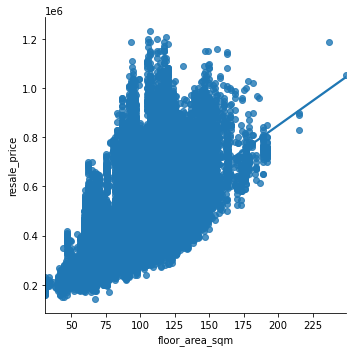

In [89]:
sns.lmplot(data=HDB_2020, x="floor_area_sqm", y='resale_price')

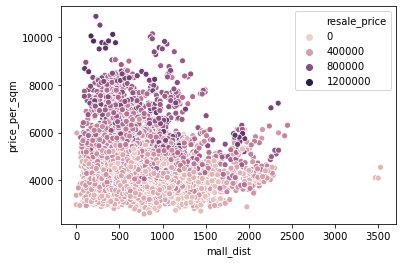

In [82]:
mean_prices['price_per_sqm'] = mean_prices['resale_price']/mean_prices['floor_area_sqm']
sns.scatterplot(data=mean_prices, x="mall_dist", y='price_per_sqm', hue='resale_price')

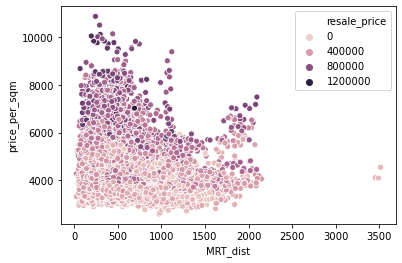

In [83]:
sns.scatterplot(data=mean_prices, x="MRT_dist", y='price_per_sqm', hue='resale_price')

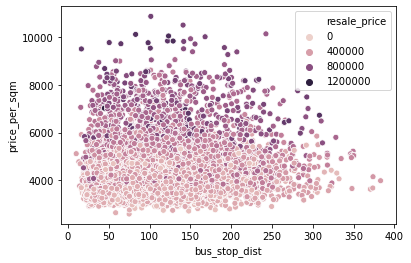

In [66]:
sns.scatterplot(data=mean_prices, x="bus_stop_dist", y='price_per_sqm', hue='resale_price')

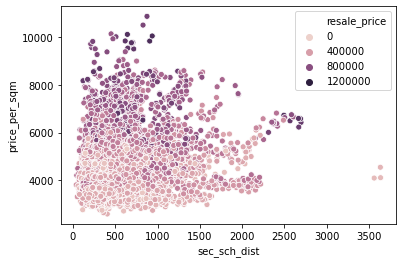

In [67]:
sns.scatterplot(data=mean_prices, x="sec_sch_dist", y='price_per_sqm', hue='resale_price')

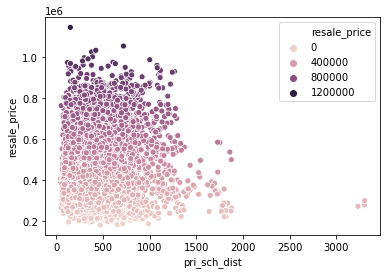

In [68]:
sns.scatterplot(data=mean_prices, x="pri_sch_dist", y="resale_price", hue='resale_price')